The code in this notebook is from this link: https://www.tensorflow.org/tutorials/load_data/images  

Data from: https://www.kaggle.com/datasets/shrutisaxena/yoga-pose-image-classification-dataset

**What's next?** 
- Måske normalize dataen, men ikke sikkert det gør det bedre
    - https://stackoverflow.com/questions/63572451/normalizing-batchdataset-in-tensorflow-2-3
- val_ds er test data
- Train_ds er train data 
- Ikke nødvendigt at have y og x
- Overvej at lave et mindre dataset - evt udvælg 5 folders/poseringer 
- Ret modellen til (kig på hvad vi har lavet til undervisning) 
- Godt at bruge VGG16

In [2]:
import os
import sys
sys.path.append(os.path.join(".."))
import cv2
import numpy as np
from utils.imutils import jimshow
from utils.imutils import jimshow_channel
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import pathlib
import PIL
import PIL.Image

# sklearn
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

# tensorflow
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten,Dense,Dropout,BatchNormalization, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model


2022-05-13 09:14:26.996123: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.9/site-packages/cv2/../../lib64:
2022-05-13 09:14:26.996161: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [20]:
data = "input"
data_dir = pathlib.Path(data)

data_dir

PosixPath('input')

In [23]:
data_set = os.path.join(data)
data_set

'input'

In [21]:
image_count = len(list(data_dir.glob('*/*')))
print(("The dataset has {image_count} images.") \
      .format (image_count=image_count))

image_count_png = len(list(data_dir.glob('*/*.png')))
print(("{image_count_png} of the images in the dataset is .png files.") \
      .format(image_count_png=image_count_png))

The dataset has 6006 images.
5897 of the images in the dataset is .png files.


In [25]:
# process to normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

# The map() function executes a specified function for each item in an iterable. 
ds = ds.map(process)

Found 6023 files belonging to 107 classes.


In [26]:
# Define some parameters for the loader
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). 

It's good practice to use a validation split when developing your model. You will use 80% of the images for training and 20% for validation.

In [61]:
# split the dataset into train (80%) and test (20%)
train = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE)

# normalize data
train_norm = train.map(process)

type(train_norm)

Found 6023 files belonging to 107 classes.
Using 4819 files for training.


tensorflow.python.data.ops.dataset_ops.MapDataset

In [48]:
# split the dataset into train (80%) and test (20%)
test = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

# normalize data
test_norm = test.map(process)

Found 6023 files belonging to 107 classes.
Using 1204 files for validation.


In [63]:
# find the class names in the class_names attribute on these datasets.

class_names = train.class_names
#print(class_names)

In [35]:
type(train_norm)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [36]:
type(train)

tensorflow.python.data.ops.dataset_ops.BatchDataset

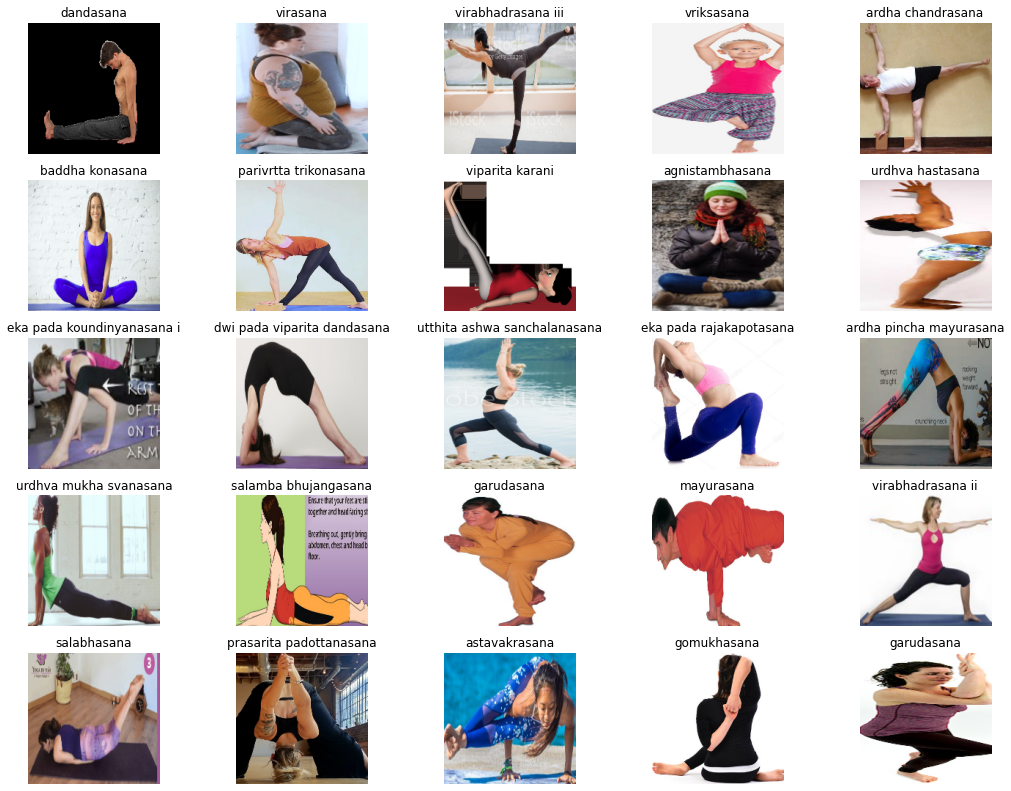

In [66]:
# display 25 images from the training dataset.
plt.figure(figsize=(18,14))
for images, labels in train.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [68]:
# clear models and parameters stored in memory
tf.keras.backend.clear_session()

In [69]:
#code from lesson 10
model = VGG16(include_top = False,
                  pooling = "avg",
                  input_shape = (180,180,3))
 
# disable training of Conv layers
for layer in model.layers:
    layer.trainable = False 
    
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation = 'relu')(flat1)
output = Dense(10, activation = 'softmax')(class1)

# define new model
model = Model(inputs=model.inputs,
              outputs=output)
    
 # compile
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.01,
    decay_steps = 10000,
    decay_rate = 0.9)

sgd = SGD(learning_rate = lr_schedule)

model.compile(optimizer = sgd,
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [70]:
H = model.fit(train,
              validation_data = test,
              batch_size = 128,
              epochs = 3,
              verbose = 1)

Epoch 1/3


ValueError: in user code:

    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/conda/lib/python3.9/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/opt/conda/lib/python3.9/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/losses.py", line 1789, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/opt/conda/lib/python3.9/site-packages/keras/backend.py", line 5083, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 10) are incompatible


In [51]:
model = Sequential()
model.add(Dense(256, input_shape=(180,180,3), activation = "relu"))
model.add(Dense(128, activation = "relu"))
model.add(Dense(10, activation = "softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 180, 180, 256)     1024      
                                                                 
 dense_8 (Dense)             (None, 180, 180, 128)     32896     
                                                                 
 dense_9 (Dense)             (None, 180, 180, 10)      1290      
                                                                 
Total params: 35,210
Trainable params: 35,210
Non-trainable params: 0
_________________________________________________________________


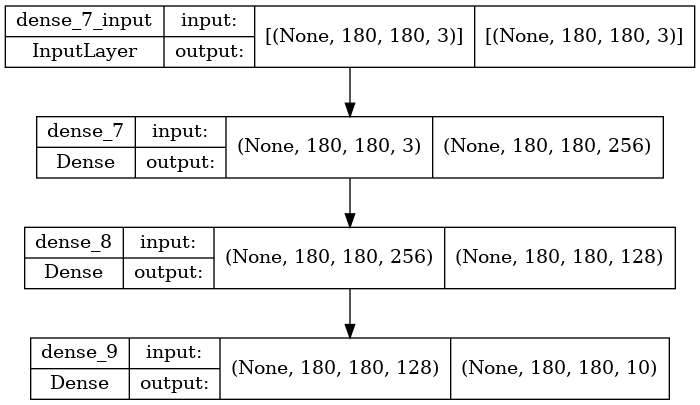

In [52]:
plot_model(model, show_shapes = True, show_layer_names = True)

In [54]:
history = model.fit(train,
                    validation_data = test,
                    epochs=3,
                    batch_size=32)

Epoch 1/3


ValueError: in user code:

    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/conda/lib/python3.9/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/opt/conda/lib/python3.9/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/losses.py", line 1789, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/opt/conda/lib/python3.9/site-packages/keras/backend.py", line 5083, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None,) and (None, 180, 180, 10) are incompatible


In [55]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  train,
  validation_data=test,
  epochs=3
)

Epoch 1/3


/opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/opt/conda/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.9/site-packages/traitlets/config/application.py", line 845, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 667, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 456, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 445, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 352, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 647, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 345, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2898, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2944, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3169, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3361, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_665/1996855066.py", line 1, in <module>
      model.fit(
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/conda/lib/python3.9/site-packages/keras/losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "/opt/conda/lib/python3.9/site-packages/keras/losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/losses.py", line 1862, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/opt/conda/lib/python3.9/site-packages/keras/backend.py", line 5202, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [1036800,10] and labels shape [32]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_3448]

In [109]:
# Binarize labels
#lb = LabelBinarizer()
#train_norm = lb.fit_transform(train_norm)
#y_test = lb.fit_transform(y_test)

In [58]:
predictions = model.predict(test, batch_size = 128)
    
# print the classification report to the terminal
report = classification_report(test.argmax(axis=1),
                               predictions.argmax(axis=1),
                               target_names=labels)
print(report)

2022-05-13 09:38:24.283498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


AttributeError: 'BatchDataset' object has no attribute 'argmax'